## Limpieza del dataset

In [1]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno



In [2]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
data_raw = pd.read_csv(r'..\data\data_raw.csv', parse_dates=True)

In [3]:
data_raw.columns

Index(['date', 'ticker', 'year_x', 'trade_date', 'close_reb_adj', 'vol_1y',
       'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y', 'None',
       'report_date', 'financial_year_end_date', 'revenue', 'eps', 'ebitda',
       'netinc', 'roe', 'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit',
       'currentratio', 'capex', 'ncfo', 'equity', 'de', 'year_y',
       'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy', 'equity_yoy',
       'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'rebalance_date', 'closeadj', 'ret_6m', 'ret_12m', 'target_12m_shift',
       'next_exit_date', 'target_12m_final', 'index', 'risk_free_rate',
       'sharpe_1y'],
      dtype='object')

In [4]:
print("Shape del dataset:", data_raw.shape)
print("\nPrimeras filas:")
display(data_raw.head())

# Número de tickers y años únicos
n_tickers = data_raw['ticker'].nunique()
years = pd.to_datetime(data_raw['date']).dt.year.unique()
print(f"Número de tickers únicos: {n_tickers}")
print(f"Años cubiertos: {years.min()} - {years.max()} ({len(years)} años)")


Shape del dataset: (14045, 51)

Primeras filas:


,date,ticker,year_x,trade_date,close_reb_adj,vol_1y,max_1y,min_1y,sma_1y,sma_2y,...,rebalance_date,closeadj,ret_6m,ret_12m,target_12m_shift,next_exit_date,target_12m_final,index,risk_free_rate,sharpe_1y
0,1998-03-31,GWW,1998.0,1998-03-31,32.910,11078200.0,32.974,29.972,31.460607,31.460607,...,1998-03-31,32.910,NaN,NaN,-0.151200,NaN,-0.151200,0,5.6555,-1.053084
1,1998-03-31,FCN1,1998.0,1998-03-31,87.697,54968300.0,90.603,71.356,79.785016,79.785016,...,1998-03-31,87.697,NaN,NaN,NaN,1998-10-02,-0.268789,0,5.6555,-1.319834
2,1998-03-31,FCX,1998.0,1998-03-31,5.788,91016200.0,5.933,3.901,4.454377,4.454377,...,1998-03-31,5.788,NaN,NaN,-0.448860,NaN,-0.448860,0,5.6555,-1.089604
3,1998-03-31,HRB,1998.0,1998-03-31,5.144,84888000.0,5.273,4.323,4.849443,4.849443,...,1998-03-31,5.144,NaN,NaN,0.017691,2020-09-21,0.017691,0,5.6555,-0.144706
4,1998-03-31,SIAL,1998.0,1998-03-31,15.580,54066200.0,17.848,15.397,16.437180,16.437180,...,1998-03-31,15.580,NaN,NaN,-0.207125,2015-11-18,-0.207125,0,5.6555,-0.762508


Número de tickers únicos: 1132
Años cubiertos: 1998 - 2025 (28 años)


##### Columnas a mantener. Elimninamos columnas repetidas, fechas, precios, etc. Dejamos ticker ya que posteriormente haremos fill de nan's agrupando por ticker pero finalmente se eliminará para no dejar al modelo reconocer una misma empresa a lo largo del tiempo.

In [5]:
data_clean = data_raw[['ticker','date','vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y', 'volatility_1y', 
       'revenue', 'eps', 'ebitda','netinc', 'roe', 'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 
       'ebit','currentratio', 'capex', 'ncfo', 'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy', 'equity_yoy',
       'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate','target_12m_final', 'sharpe_1y']
]

##### Análisis de Datos Faltanates: 

La Figura 1 muestra la matriz de valores faltantes. Se observa que la mayor parte de las variables presenta un nivel de completitud elevado, con datos ausentes localizados principalmente en current ratio. Además se observa que para la primera ventana (1998) no hay datos fundamentales ya que no se puedo usar los datos del año fiscal 1997. Tampoco de momentum dada la necesidad de una base comparable.

La Figura 2 representa la correlación de ausencia de datos entre variables. Destaca que los faltantes en variables fundamentales están altamente correlacionados: cuando una de ellas no está disponible para una observación, las demás suelen estar ausentes también, reflejando la no disponibilidad de información financiera para esa empresa en ese año. Por el contrario, las variables técnicas y de precios rara vez presentan datos faltantes y su completitud no depende de la de los fundamentales.


<Figure size 4600x1800 with 0 Axes>

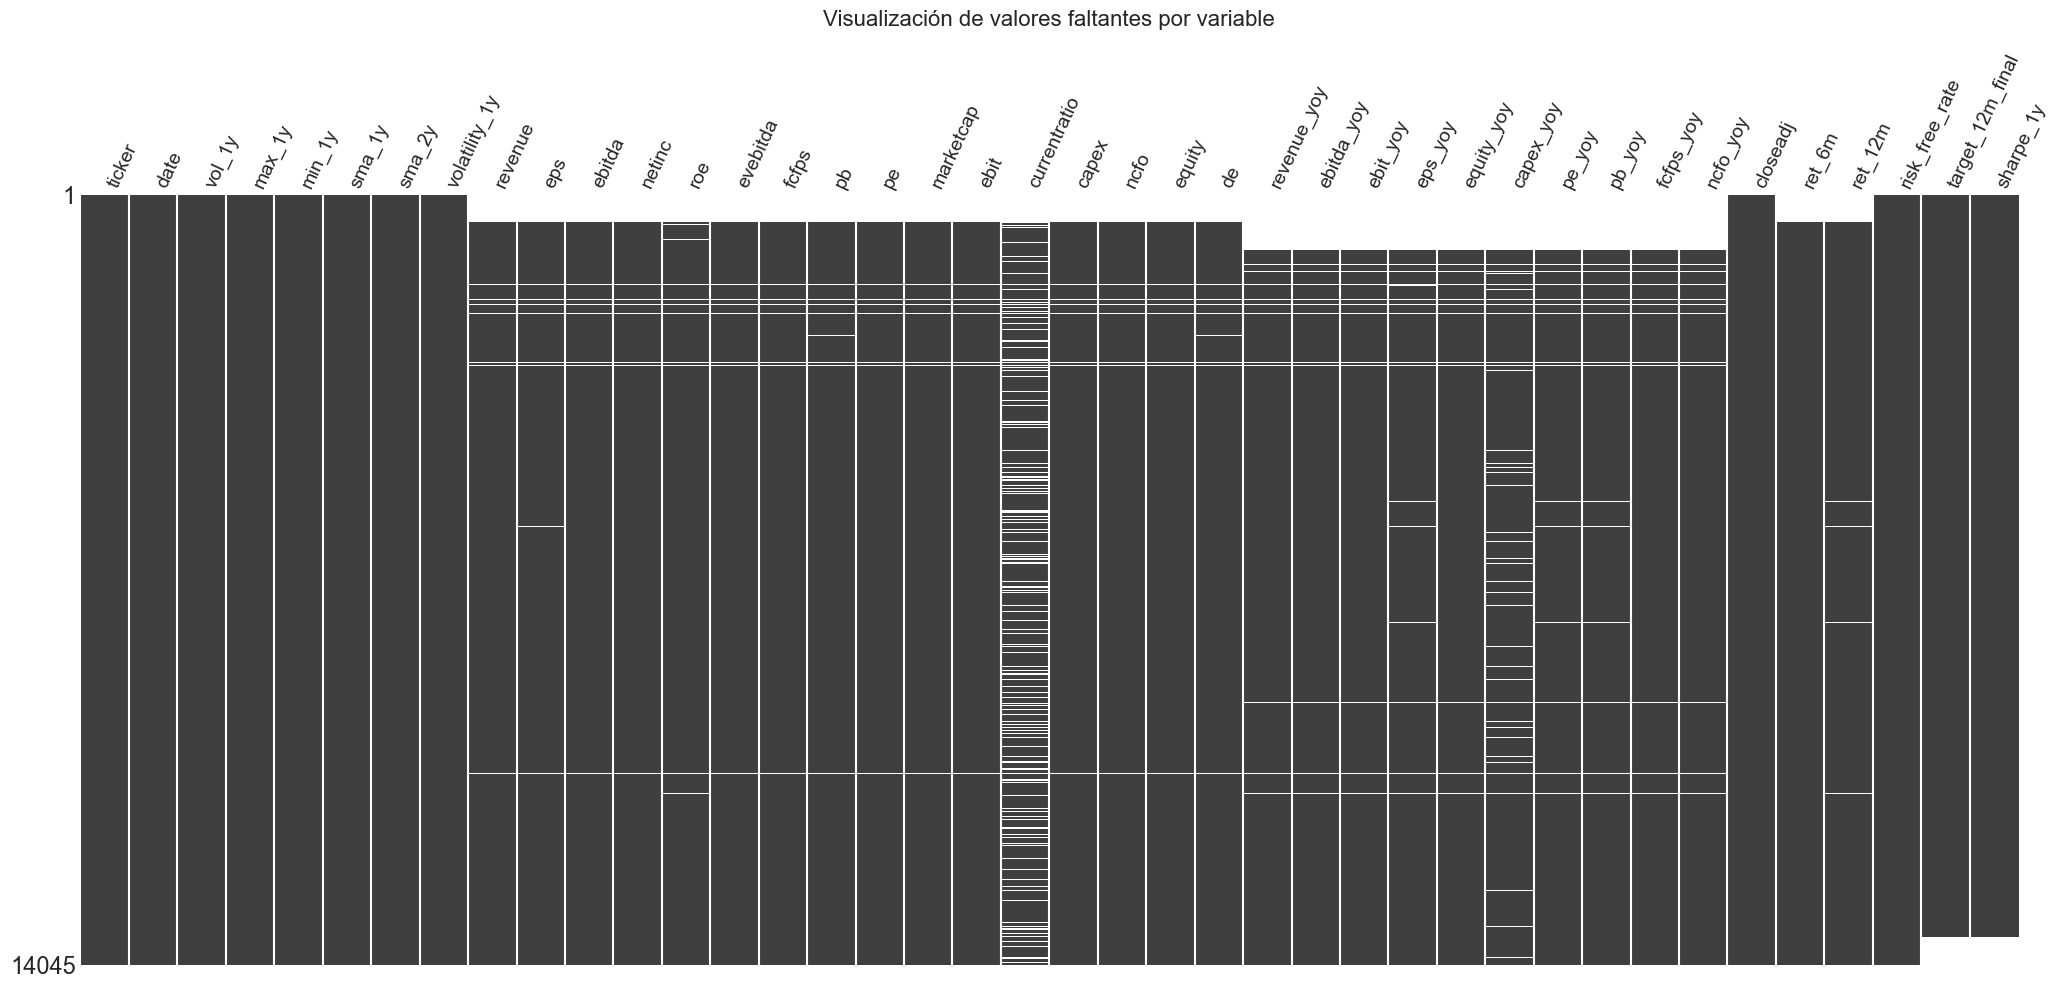

<Figure size 1400x1200 with 0 Axes>

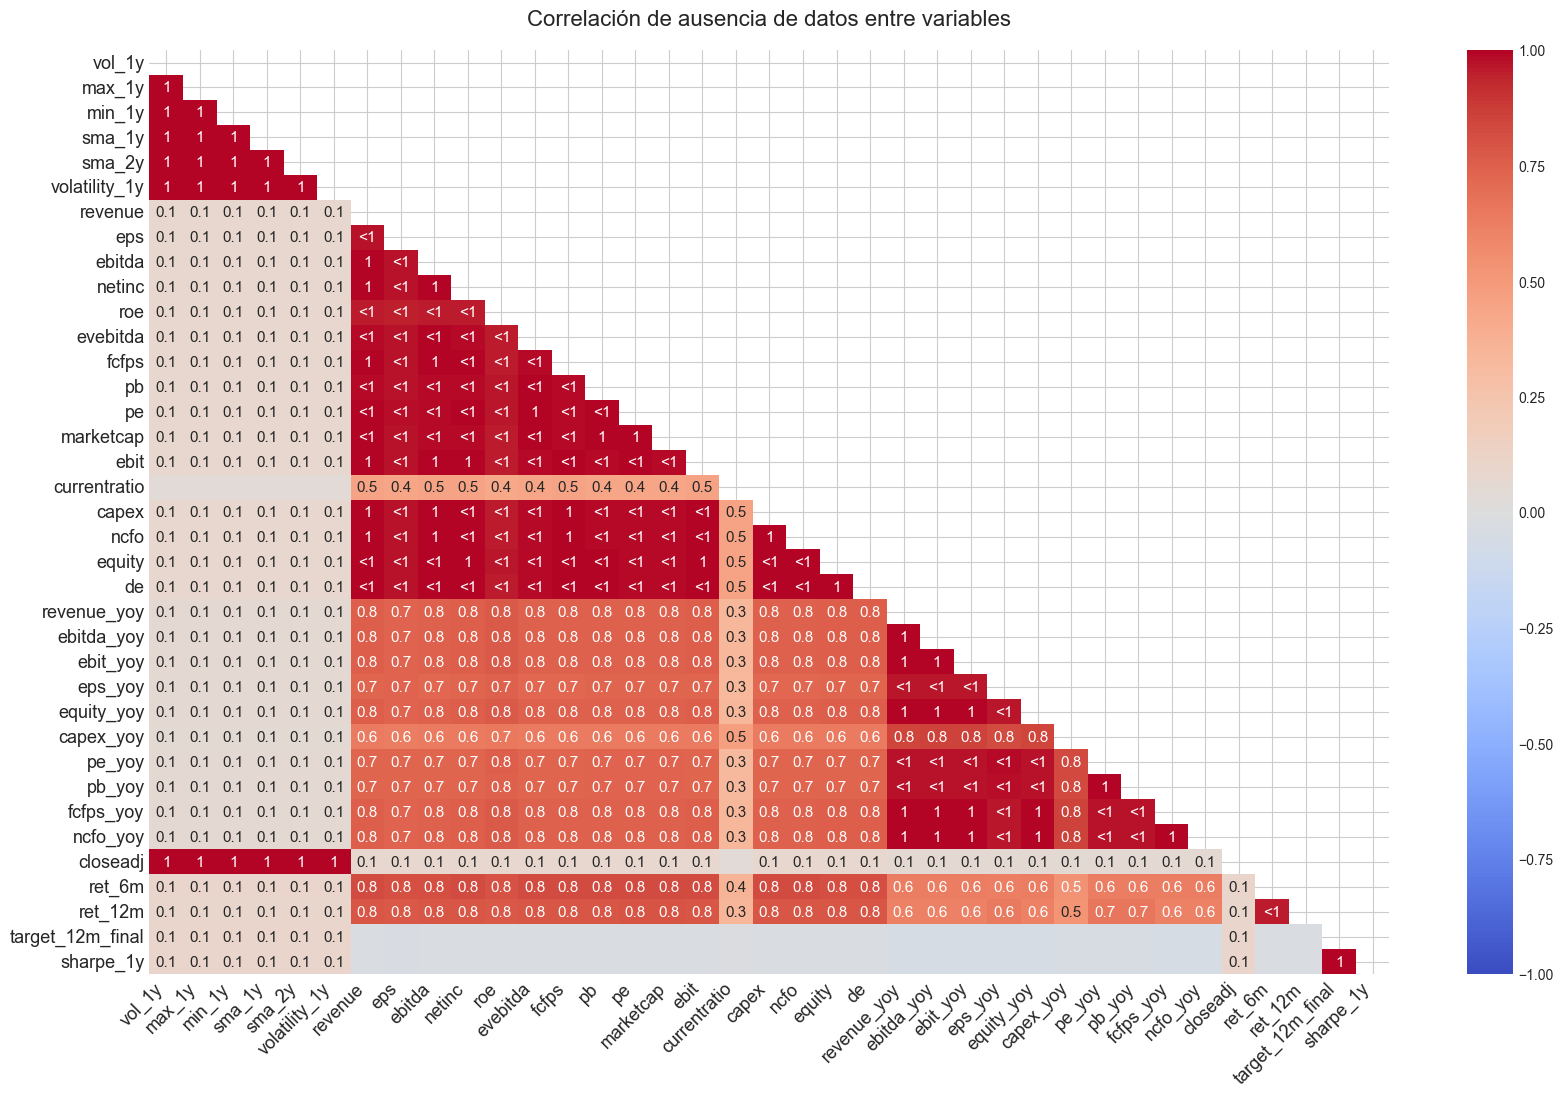

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_11764\4044414108.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nan_percent.index, y=nan_percent.values, palette='Blues_r')


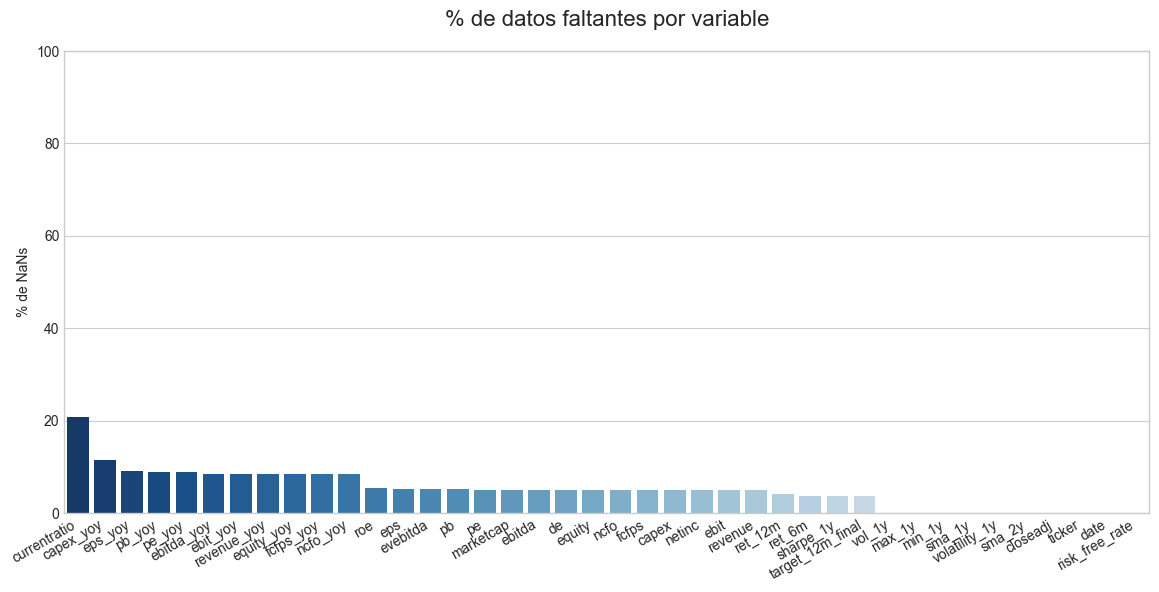

,currentratio,capex_yoy,eps_yoy,pb_yoy,pe_yoy,ebitda_yoy,ebit_yoy,revenue_yoy,equity_yoy,fcfps_yoy,...,vol_1y,max_1y,min_1y,sma_1y,volatility_1y,sma_2y,closeadj,ticker,date,risk_free_rate
n_faltantes,2929,1596,1269,1258,1257,1197,1197,1196,1196,1196,...,5,5,5,5,5,5,5,0,0,0


In [6]:

# Estilo y fuentes para gráficos más bonitos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 10, 
    'axes.titlesize': 16, 
    'axes.labelsize': 10,
    'axes.titlepad': 18
})

# 1. Matrix de valores faltantes
plt.figure(figsize=(46,18))
msno.matrix(data_clean, fontsize=14, sparkline=False, width_ratios=(0.95, 0.05))
plt.title("Visualización de valores faltantes por variable")
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=65, ha='left')
plt.show()

# 2. Heatmap de correlación de ausencia de datos
plt.figure(figsize=(14,12))
msno.heatmap(data_clean, cmap="coolwarm", fontsize=13)
plt.title("Correlación de ausencia de datos entre variables")
plt.show()

# 3. Barplot de % de datos faltantes por columna
nan_percent = data_clean.isnull().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(14,6))
sns.barplot(x=nan_percent.index, y=nan_percent.values, palette='Blues_r')
plt.title('% de datos faltantes por variable')
plt.ylabel('% de NaNs')
plt.xlabel('')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 100)
plt.show()

# 4. Tabla rápida de NaNs para tu memoria
display(data_clean.isnull().sum().sort_values(ascending=False).to_frame('n_faltantes').T)


##### 1. Eliminamos La primera y la última ventana ya que 1998 aún no tiene datos fundamentales (se usarían los datos de Año Fiscal 1997 que no se extrajeron) y 2025 no tiene variable de target completada ya que se desconocen los retornos a fecha de hoy 29/05/2025

In [7]:
data_clean = data_clean[data_clean['date'] != "1998-03-31"]
data_clean = data_clean[data_clean['date'] != "2025-03-31"]

##### Parece que sigue habiendo filas para las cuales no se puedo recuperar datos fundamentales. Además current ratio presenta un alto número de valores faltantes

In [8]:
data_clean.isna().sum()

ticker                 0
date                   0
vol_1y                 4
max_1y                 4
min_1y                 4
sma_1y                 4
sma_2y                 4
volatility_1y          4
revenue              200
eps                  233
ebitda               205
netinc               201
roe                  257
evebitda             214
fcfps                202
pb                   211
pe                   209
marketcap            206
ebit                 201
currentratio        2346
capex                202
ncfo                 202
equity               202
de                   203
revenue_yoy          693
ebitda_yoy           694
ebit_yoy             694
eps_yoy              764
equity_yoy           693
capex_yoy           1077
pe_yoy               751
pb_yoy               752
fcfps_yoy            693
ncfo_yoy             693
closeadj               4
ret_6m                30
ret_12m               77
risk_free_rate         0
target_12m_final       5
sharpe_1y              5


#### 2. Se decide eliminar la columna dado su impacto limitado 

In [9]:
data_clean = data_clean.drop(columns=['currentratio'])

In [10]:
data_clean[data_clean["closeadj"].isnull()]


,ticker,date,vol_1y,max_1y,min_1y,sma_1y,sma_2y,volatility_1y,revenue,eps,...,pe_yoy,pb_yoy,fcfps_yoy,ncfo_yoy,closeadj,ret_6m,ret_12m,risk_free_rate,target_12m_final,sharpe_1y
652,SHEL,1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2336,NaN,NaN
1098,SHEL,2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0086,NaN,NaN
1638,SHEL,2001-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9106,NaN,NaN
2125,SHEL,2002-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4019,NaN,NaN


##### 3. Eliminamos filas con un porcentaje de NaN's superior al 70%

In [11]:
missing_threshold = int(data_clean.shape[1] * 0.7)
data_clean = data_clean[data_clean.isnull().sum(axis=1) <= missing_threshold]


#### 4. Para columnas no fundamentales, en caso de que el valor faltante no ocurra en la primera aparición de la empresa, se realiza un forward fill tomando el dato disponible inmediatamente anterior 

In [12]:
ffill_cols = [
    'vol_1y', 'max_1y', 'min_1y',
    'sma_1y', 'sma_2y', 'volatility_1y',

]


# Asegurar orden temporal por ticker y fecha
data_clean = data_clean.sort_values(by=['ticker', 'date'])

# Aplicar ffill solo a las columnas seleccionadas, por ticker
data_clean[ffill_cols] = (
    data_clean.groupby('ticker')[ffill_cols]
    .apply(lambda g: g.fillna(method='ffill'))
    .reset_index(level=0, drop=True)  # Mantiene el índice original del DataFrame
)



C:\Users\Ignacio\AppData\Local\Temp\ipykernel_11764\3763455557.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .apply(lambda g: g.fillna(method='ffill'))


#### 5. Para el resto de columnas imputamos con la media, esto en esencia hace que el modelo no tenga en cuenta dichos valores imputados 

In [13]:


# Asegurar que 'date' es datetime
data_clean['date'] = pd.to_datetime(data_clean['date'])

# Columnas a imputar
cols_ffill = [
    # Fundamentales
    'revenue', 'eps', 'ebitda', 'netinc', 'roe', 'evebitda', 'fcfps',
    'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo', 'equity', 'de',
    # YoY 
    'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy', 'equity_yoy', 'capex_yoy',
    'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
    # Precios y retornos
    'ret_6m', 'ret_12m'
]

# Paso 1: Añadir una categoría temporal de tercil por marketcap para imputación
data_clean['_marketcap_tercil'] = data_clean.groupby(data_clean['date'].dt.year)['marketcap'] \
    .transform(lambda x: pd.qcut(x, q=3, labels=['low', 'mid', 'high']))

# Paso 2: Imputar por mediana según año y tercil de marketcap
for col in cols_ffill:
    data_clean[col] = data_clean.groupby(
        [data_clean['date'].dt.year, data_clean['_marketcap_tercil']]
    )[col].transform(lambda x: x.fillna(x.median()))

# Paso 3: Fallback — mediana del año completo si aún quedan NaNs
data_clean[cols_ffill] = data_clean.groupby(
    data_clean['date'].dt.year
)[cols_ffill].transform(lambda x: x.fillna(x.median()))

# Paso 4: Eliminar columna auxiliar
data_clean.drop(columns=['_marketcap_tercil'], inplace=True)


C:\Users\Ignacio\AppData\Local\Temp\ipykernel_11764\564571833.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_clean[col] = data_clean.groupby(
C:\Users\Ignacio\AppData\Local\Temp\ipykernel_11764\564571833.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_clean[col] = data_clean.groupby(
C:\Users\Ignacio\AppData\Local\Temp\ipykernel_11764\564571833.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dat

In [14]:
data_clean.isna().sum()

ticker              0
date                0
vol_1y              0
max_1y              0
min_1y              0
sma_1y              0
sma_2y              0
volatility_1y       0
revenue             0
eps                 0
ebitda              0
netinc              0
roe                 0
evebitda            0
fcfps               0
pb                  0
pe                  0
marketcap           0
ebit                0
capex               0
ncfo                0
equity              0
de                  0
revenue_yoy         0
ebitda_yoy          0
ebit_yoy            0
eps_yoy             0
equity_yoy          0
capex_yoy           0
pe_yoy              0
pb_yoy              0
fcfps_yoy           0
ncfo_yoy            0
closeadj            0
ret_6m              0
ret_12m             0
risk_free_rate      0
target_12m_final    1
sharpe_1y           1
dtype: int64

#### Para las filas aún con valores faltantes (Faltantes en la variable target o sharpe_1y) simplemente eliminamos ya que no podemos inventarnos datos fundamentales y no tiene sentido promediar con datos futuros (look ahead bias) o con datos de empresas en el mismo año.

In [15]:
data_clean = data_clean.dropna()


In [16]:
data_clean.to_csv(r'..\data\data_clean.csv', index=False)

In [17]:
len(data_clean)

13037

In [18]:
data_clean[data_clean['ticker'] == 'AAPL']

,ticker,date,vol_1y,max_1y,min_1y,sma_1y,sma_2y,volatility_1y,revenue,eps,...,pe_yoy,pb_yoy,fcfps_yoy,ncfo_yoy,closeadj,ret_6m,ret_12m,risk_free_rate,target_12m_final,sharpe_1y
839,AAPL,1999-03-31,1.201984e+11,0.349,0.188,0.258909,0.240150,0.558725,5.941000e+09,0.021,...,0.038443,0.038353,0.000000,0.000000,0.270,-0.059233,0.304348,5.233600,2.777778,4.877965
1415,AAPL,2000-03-31,1.322180e+11,1.083,0.255,0.578332,0.419063,0.643883,6.134000e+09,0.037,...,0.536790,0.581225,-0.127273,0.029677,1.020,1.142857,2.777778,6.008600,-0.674510,-1.140884
1982,AAPL,2001-03-31,1.234202e+11,1.020,0.210,0.547171,0.561299,0.862587,7.983000e+09,0.043,...,-0.769825,-0.772552,-0.166667,0.035088,0.332,-0.142119,-0.674510,4.910600,0.072289,0.026876
2458,AAPL,2002-03-31,8.581031e+10,0.400,0.225,0.318391,0.436288,0.574943,5.363000e+09,-0.001,...,-48.899968,0.596610,-1.050000,-0.776029,0.356,0.527897,0.072289,5.401900,-0.404494,-0.797494
2613,AAPL,2003-03-31,6.953108e+10,0.392,0.204,0.255427,0.286401,0.441550,5.742000e+09,0.003,...,-1.265479,-0.339172,1.000000,-0.518919,0.212,-0.027523,-0.404494,3.801900,0.915094,1.986355
3474,AAPL,2004-03-31,8.136332e+10,0.419,0.197,0.313746,0.284222,0.392336,6.207000e+09,0.003,...,0.338433,0.377510,-2.500000,2.247191,0.406,0.305466,0.915094,3.840117,2.083744,5.213236
3935,AAPL,2005-03-31,1.588330e+11,1.354,0.387,0.735446,0.524177,0.409954,8.279000e+09,0.013,...,-0.130263,1.895044,5.000000,2.231834,1.252,1.151203,2.083744,4.492800,0.505591,1.123695
4262,AAPL,2006-03-31,1.843996e+11,2.572,1.026,1.627466,1.183226,0.399776,1.393100e+10,0.059,...,-0.504934,0.627996,1.805556,1.714133,1.885,0.170081,0.505591,4.853296,0.481167,1.082192
4606,AAPL,2007-03-31,2.095334e+11,2.918,1.523,2.261422,1.941931,0.361046,1.931500e+10,0.084,...,-0.189151,-0.096623,-0.346535,-0.124260,2.792,0.206569,0.481167,4.652404,0.544771,1.380009
5360,AAPL,2008-03-31,2.731123e+11,6.006,2.712,4.224833,3.245838,0.427739,2.400600e+10,0.144,...,0.122640,0.355656,1.969697,1.463964,4.313,-0.064831,0.544771,3.425123,-0.267563,-0.705604


13037! antes era 12700 columnas, por lo que hemos ganado 200 filas creando las variables de crecimiento antes de hacer el merge con constituyentes

In [19]:
for date, group in data_clean.groupby('date'):
    print(f"Fecha: {date.date()} → {len(group)} filas")


Fecha: 1999-03-31 → 499 filas
Fecha: 2000-03-31 → 499 filas
Fecha: 2001-03-31 → 499 filas
Fecha: 2002-03-31 → 499 filas
Fecha: 2003-03-31 → 500 filas
Fecha: 2004-03-31 → 500 filas
Fecha: 2005-03-31 → 500 filas
Fecha: 2006-03-31 → 500 filas
Fecha: 2007-03-31 → 500 filas
Fecha: 2008-03-31 → 500 filas
Fecha: 2009-03-31 → 500 filas
Fecha: 2010-03-31 → 499 filas
Fecha: 2011-03-31 → 500 filas
Fecha: 2012-03-31 → 500 filas
Fecha: 2013-03-31 → 500 filas
Fecha: 2014-03-31 → 500 filas
Fecha: 2015-03-31 → 502 filas
Fecha: 2016-03-31 → 504 filas
Fecha: 2017-03-31 → 505 filas
Fecha: 2018-03-31 → 505 filas
Fecha: 2019-03-31 → 505 filas
Fecha: 2020-03-31 → 505 filas
Fecha: 2021-03-31 → 505 filas
Fecha: 2022-03-31 → 505 filas
Fecha: 2023-03-31 → 503 filas
Fecha: 2024-03-31 → 503 filas
